Tratamento de Dados

In [35]:

import pandas as pd

def processar_ndvi(ndvi_path):
    df = pd.read_excel(ndvi_path, skiprows=3)
    df.columns = ['Data', 'NDVI', 'Media_Menos_Desvio', 'Media_Mais_Desvio']
    df = df.dropna(subset=['Data', 'NDVI'])
    df['Data'] = pd.to_datetime(df['Data'], format="%d/%m/%Y", errors='coerce')
    df = df.dropna(subset=['Data'])
    df['Ano'] = df['Data'].dt.year
    df['NDVI'] = pd.to_numeric(df['NDVI'], errors='coerce')
    ndvi_ano = df.groupby('Ano')['NDVI'].mean().reset_index()
    ndvi_ano.columns = ['Ano', 'NDVI_medio']
    return ndvi_ano

def processar_producao(producao_path, estado_nome):
    df = pd.read_csv(producao_path)
    df_clean = df[1:-1]
    df_clean = df_clean.iloc[:, 0].str.split(";", expand=True)
    colunas = ['Municipio', 'Produto'] + [str(ano) for ano in range(1990, 2024)]
    df_clean.columns = colunas[:df_clean.shape[1]]
    df_long = df_clean.melt(id_vars=['Municipio', 'Produto'], var_name='Ano', value_name='Producao')
    df_long['Ano'] = pd.to_numeric(df_long['Ano'], errors='coerce')
    df_long['Producao'] = pd.to_numeric(df_long['Producao'], errors='coerce')
    df_agrupado = df_long.groupby(['Ano', 'Produto'])['Producao'].sum().reset_index()
    df_agrupado['Estado'] = estado_nome
    return df_agrupado

# Processar todos os pares
ndvi_sp = processar_ndvi("bases/campinas_ndvi.xlsx")
producao_sp = processar_producao("bases/campinas.csv", "São Paulo")
df_sp = pd.merge(producao_sp, ndvi_sp, on='Ano', how='inner')

ndvi_df = processar_ndvi("bases/distrito_federal_ndvi.xlsx")
producao_df = processar_producao("bases/distrito_federal.csv", "Distrito Federal")
df_df = pd.merge(producao_df, ndvi_df, on='Ano', how='inner')

ndvi_pi = processar_ndvi("bases/piaui_norte_ndvi.xlsx")
producao_pi = processar_producao("bases/piaui_norte.csv", "Piauí Norte")
df_pi = pd.merge(producao_pi, ndvi_pi, on='Ano', how='inner')

# Concatenar todas as regiões em uma tabela só
tabela_final_completa = pd.concat([df_df, df_pi, df_sp], ignore_index=True)
tabela_final_completa = tabela_final_completa[['Estado', 'Ano', 'Produto', 'Producao', 'NDVI_medio']]

# Exportar para CSV
tabela_final_completa.to_csv("bases/tabela_final_completa.csv", index=False)


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Correlação

Matriz de correlação entre Produção e NDVI médio:
            Producao  NDVI_medio
Producao    1.000000    0.423086
NDVI_medio  0.423086    1.000000


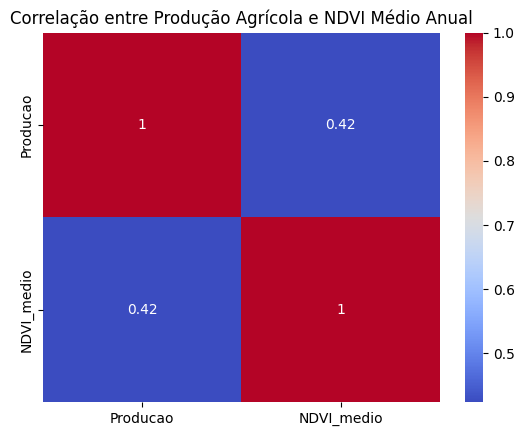

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carregar o dataset final exportado anteriormente
df = pd.read_csv("tabela_final_completa.csv")

# Agrupar por Estado e Ano, somando a produção total e mantendo a média do NDVI
df_agrupado = df.groupby(['Estado', 'Ano']).agg({
    'Producao': 'sum',
    'NDVI_medio': 'mean'
}).reset_index()

# Calcular correlação de Pearson
correlacao = df_agrupado[['Producao', 'NDVI_medio']].corr()

# Imprimir a matriz de correlação
print("Matriz de correlação entre Produção e NDVI médio:")
print(correlacao)

# Visualizar a correlação com heatmap
sns.heatmap(correlacao, annot=True, cmap='coolwarm')
plt.title("Correlação entre Produção Agrícola e NDVI Médio Anual")
plt.show()


In [28]:
import pandas as pd

# Supondo que você já tenha o DataFrame 'tabela_final_completa'
# com as colunas: ['Estado', 'Ano', 'Produto', 'Producao', 'NDVI_medio']

# Garantir que as colunas sejam numéricas
tabela_final_completa['Producao'] = pd.to_numeric(tabela_final_completa['Producao'], errors='coerce')
tabela_final_completa['NDVI_medio'] = pd.to_numeric(tabela_final_completa['NDVI_medio'], errors='coerce')

# Função para calcular correlação dentro de cada grupo de Produto
def correlacao_individual(grupo):
    if grupo['Producao'].count() >= 2 and grupo['NDVI_medio'].count() >= 2:
        return grupo[['Producao', 'NDVI_medio']].corr().iloc[0, 1]
    else:
        return None  # ignora se houver poucos dados

# Aplicar a função por Produto
correlacoes = tabela_final_completa.groupby('Produto').apply(correlacao_individual).reset_index()
correlacoes.columns = ['Produto', 'Correlacao']

# Remover correlações nulas e ordenar
correlacoes = correlacoes.dropna().sort_values(by='Correlacao', ascending=False)

# Exibir o resultado
print(correlacoes)


           Produto  Correlacao
0   Cana-de-açúcar    0.525092
1  Milho (em grão)    0.308896
2   Soja (em grão)   -0.343195


<ipython-input-28-1451e121b8cd>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlacoes = tabela_final_completa.groupby('Produto').apply(correlacao_individual).reset_index()


Modelo

In [29]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Suponha que 'tabela_final_completa' já esteja carregado com:
# ['Estado', 'Ano', 'Produto', 'Producao', 'NDVI_medio']

# Garantir tipos corretos
df = tabela_final_completa.copy()
df['Producao'] = pd.to_numeric(df['Producao'], errors='coerce')
df['NDVI_medio'] = pd.to_numeric(df['NDVI_medio'], errors='coerce')
df['Ano'] = pd.to_numeric(df['Ano'], errors='coerce')

# Remover valores nulos
df = df.dropna(subset=['Producao', 'NDVI_medio', 'Ano', 'Produto'])

# Regressão com variáveis explicativas NDVI, Ano e Produto como dummies
modelo = smf.ols(formula='Producao ~ NDVI_medio + Ano + C(Produto)', data=df).fit()

# Mostrar o resumo do modelo
print(modelo.summary())


                            OLS Regression Results                            
Dep. Variable:               Producao   R-squared:                       0.159
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     9.983
Date:                Mon, 26 May 2025   Prob (F-statistic):           2.04e-07
Time:                        23:12:09   Log-Likelihood:                -2686.0
No. Observations:                 216   AIC:                             5382.
Df Residuals:                     211   BIC:                             5399.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Gráficos

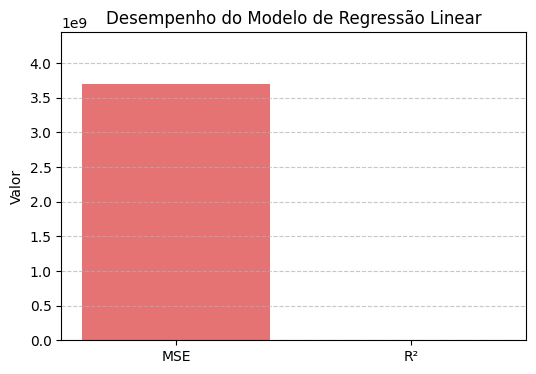

In [30]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Preparar os dados
df = tabela_final_completa.copy()
df['Producao'] = pd.to_numeric(df['Producao'], errors='coerce')
df['NDVI_medio'] = pd.to_numeric(df['NDVI_medio'], errors='coerce')
df['Ano'] = pd.to_numeric(df['Ano'], errors='coerce')
df = df.dropna(subset=['Producao', 'NDVI_medio', 'Ano', 'Produto'])

# Ajustar o modelo de regressão linear
modelo = smf.ols(formula='Producao ~ NDVI_medio + Ano + C(Produto)', data=df).fit()

# Fazer previsões
df['Producao_Prevista'] = modelo.predict(df)

# Calcular métricas de avaliação
mse = mean_squared_error(df['Producao'], df['Producao_Prevista'])
r2 = r2_score(df['Producao'], df['Producao_Prevista'])

# Plotar MSE e R²
plt.figure(figsize=(6, 4))
plt.bar(['MSE', 'R²'], [mse, r2], color=['#E57373', '#64B5F6'])
plt.title("Desempenho do Modelo de Regressão Linear")
plt.ylabel("Valor")
plt.ylim(0, max(mse, r2) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


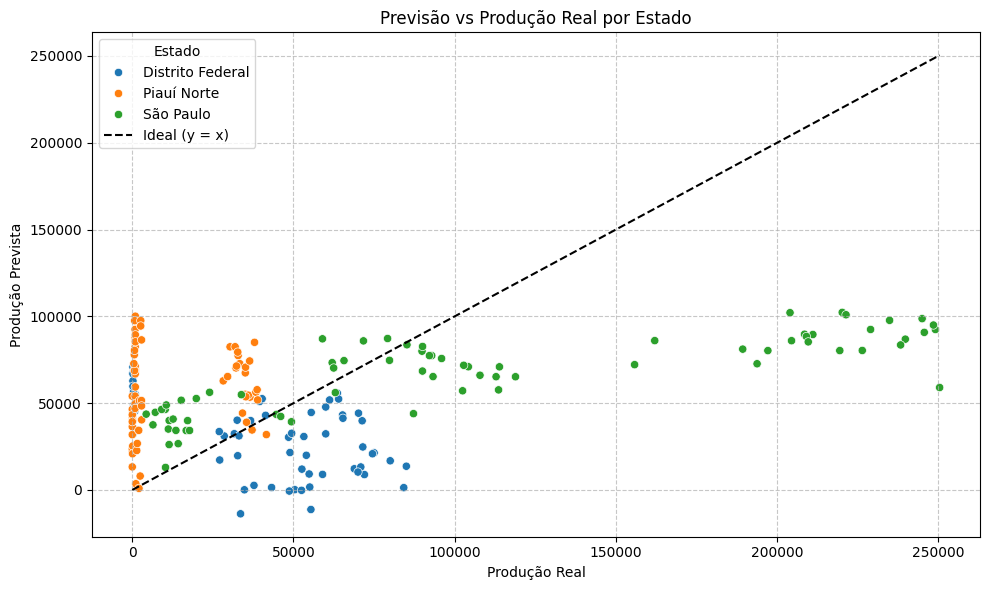

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot das previsões por Estado
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Producao', y='Producao_Prevista', hue='Estado')
plt.plot([df['Producao'].min(), df['Producao'].max()],
         [df['Producao'].min(), df['Producao'].max()],
         color='black', linestyle='--', label='Ideal (y = x)')
plt.title("Previsão vs Produção Real por Estado")
plt.xlabel("Produção Real")
plt.ylabel("Produção Prevista")
plt.legend(title="Estado")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


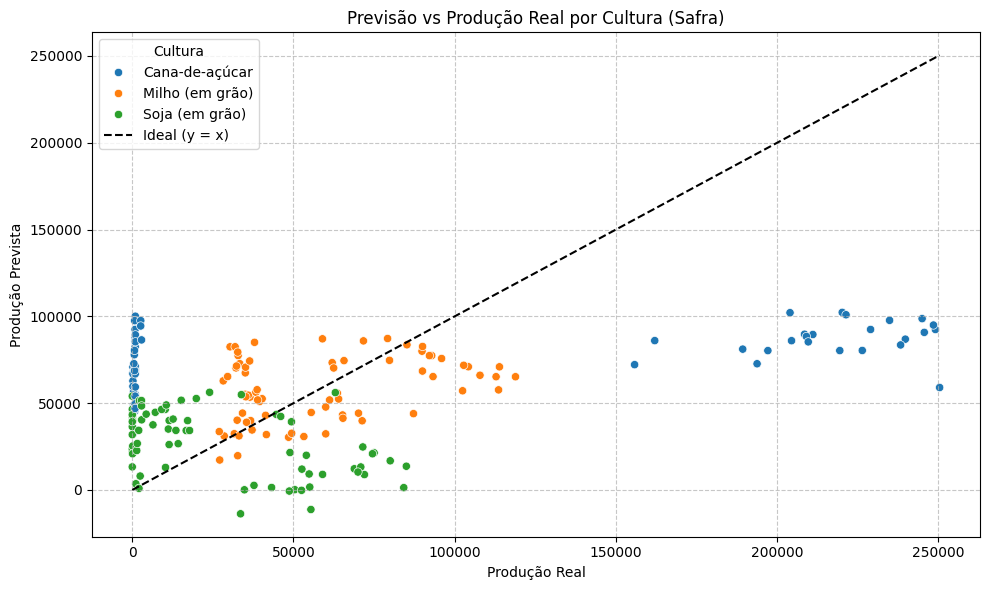

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatterplot das previsões por Produto (Safra)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Producao', y='Producao_Prevista', hue='Produto')
plt.plot([df['Producao'].min(), df['Producao'].max()],
         [df['Producao'].min(), df['Producao'].max()],
         color='black', linestyle='--', label='Ideal (y = x)')
plt.title("Previsão vs Produção Real por Cultura (Safra)")
plt.xlabel("Produção Real")
plt.ylabel("Produção Prevista")
plt.legend(title="Cultura")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
